In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import gendata
import torch
from models.wdgrl_ae import *
from tqdm.auto import trange

KeyboardInterrupt: 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
def clustering(
        X, 
        n_cluster: int):
    kmeans = KMeans(n_clusters=n_cluster, random_state=40)
    labels = kmeans.fit_predict(X)
    return labels, kmeans

## Gen data

In [29]:
ns, nt, d = 2000, 100, 16
n_clusters = 3

In [30]:
from random import randint
seed = randint(0, 2**32 - 1)
seed = 3474312631
print("Randomly choose seed =",seed)


Randomly choose seed = 3474312631


In [31]:
dataset = gendata.gen_domain_adaptation_data_k(
    ns=ns,
    nt=nt,
    n_features=d,
    n_clusters=n_clusters,
    dist=3,
    shift=0,
    std_source=[1.5,1,1.5],
    std_target= [1.9,1.5,1.9],
    random_state=seed,
)
Xs, Ys, cen_s = dataset["source"]
Xt, Yt, cen_t = dataset["target"]
ns = Xs.shape[0]
nt = Xt.shape[0]


In [32]:
Xs[1]

array([-3.60660755,  1.47127226, -2.42559533,  0.41972419, -1.30923443,
       -0.57781742,  0.48573759, -0.67006716,  0.85935367, -2.49692697,
       -2.36521049,  1.61840988, -2.45767456,  1.56367506, -5.95601285,
        1.10725445])

In [33]:
from sklearn.preprocessing import StandardScaler

# Ghép dữ liệu train của cả hai domain để fit scaler
X_train_all = np.vstack([Xs, Xt])

# Fit scaler
scaler = StandardScaler().fit(X_train_all)

# Transform cho cả source và target (train + test)
Xs = scaler.transform(Xs)
# X_source_test  = scaler.transform(X_source_test)
Xt = scaler.transform(Xt)
# X_target_test  = scaler.transform(X_target_test)

## TSNE 2d plot

Running t-SNE dimensionality reduction...


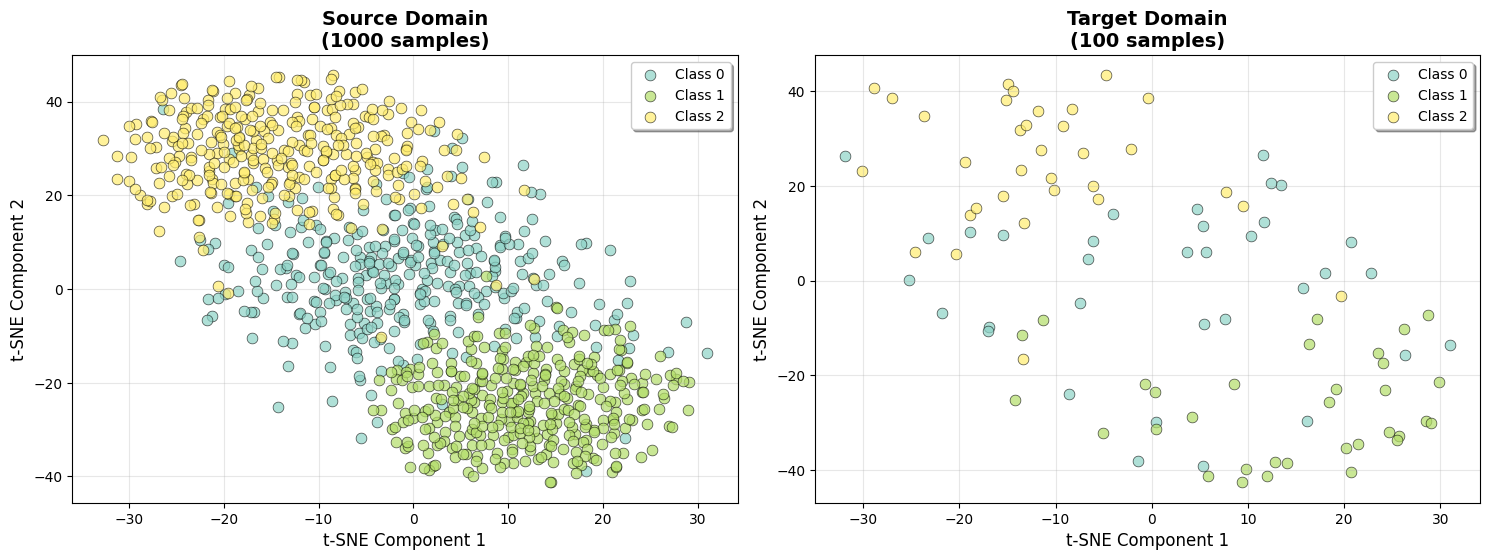

In [34]:
gendata.visualby_tsne(Xs,Xt,Ys,Yt)

## Original clustering

In [35]:
cluster_labels, model1 = clustering(Xt,n_cluster=n_clusters)

original_ari = adjusted_rand_score(Yt, cluster_labels)
print(f'Adjusted Rand Index (ARI) only on target domain: {original_ari:.4f}')
X_comb = np.vstack((Xs, Xt))
cluster_comb, kmeanC = clustering(X_comb, 2)
# print(X_comb.shape, np.hstack((ys,yt)).shape)

ariC = adjusted_rand_score(Yt, cluster_comb[ns:])
ariC

Adjusted Rand Index (ARI) only on target domain: 0.5928


0.42838146820827994

___

In [36]:
from torch.utils.data import DataLoader, TensorDataset

xs = torch.from_numpy(Xs).float()
ys = torch.from_numpy(Ys).long()
xt = torch.from_numpy(Xt).float()
yt = torch.from_numpy(Yt).long()

source_dataset = TensorDataset(xs)
target_dataset = TensorDataset(xt)


## WDGRL

In [ ]:
encoder_hidden_dims = [500,100,50]
decoder_hidden_dims = encoder_hidden_dims[::-1].copy()
critic_hidden_dims = [100]
dc_iter = 5
batch_size = 32
num_epochs = 5000

--- 

In [38]:

final_model = WDGRL(
    input_dim=d,
    encoder_hidden_dims=encoder_hidden_dims,
    decoder_hidden_dims=decoder_hidden_dims,
    critic_hidden_dims=critic_hidden_dims,
    alpha2=0.0001,
    alpha1=0.0001,
    # use_decoder=True,
    seed=42,
    reallabel=Yt
)   

# Train longer for final fit
log_loss = final_model.train(
    source_dataset,
    target_dataset,
    num_epochs=num_epochs,  # more epochs for final training
    gamma=10,
    delta=0.5,
    # with_decoder=True,
    lambda_= 1,
    dc_iter=dc_iter,
    batch_size=batch_size,
    verbose = False,
    early_stopping=False,
    patience=40,
    min_delta=1e-5,
    check_ari=True,
)



Epoch: 100%|██████████| 5000/5000 [12:37<00:00,  6.60it/s]


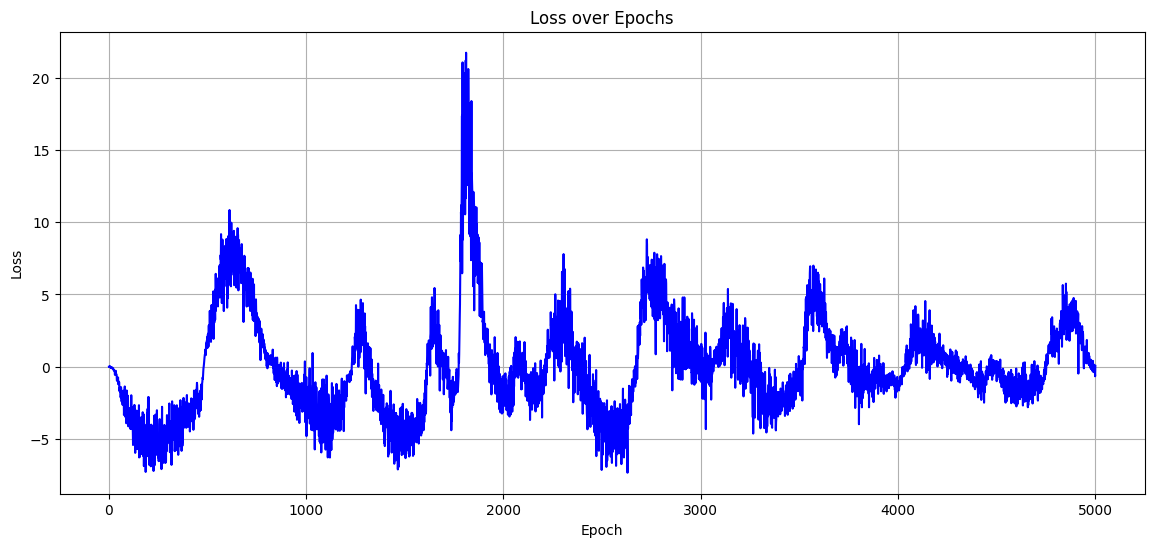

In [39]:
total_loss = log_loss["loss"]
reconstructionloss = log_loss["decoder_loss"]
log_metric = log_loss['log_ari']
epochs = range(1, len(total_loss) + 1)

plt.figure(figsize=(14, 6))
plt.plot(epochs, total_loss, linestyle='-', color='blue')

plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [22]:
epochs = range(1, len(log_metric) + 1)


In [23]:
# Split into separate lists
ari_comb = [d['ari_comb'] for d in log_metric]
silhouette_comb = [d['silhouette_comb'] for d in log_metric]
ari_Tonly = [d['ari_Tonly'] for d in log_metric]
sil_Tonly = [d['sil_Tonly'] for d in log_metric]

In [24]:
original_ari

0.5928468053664226

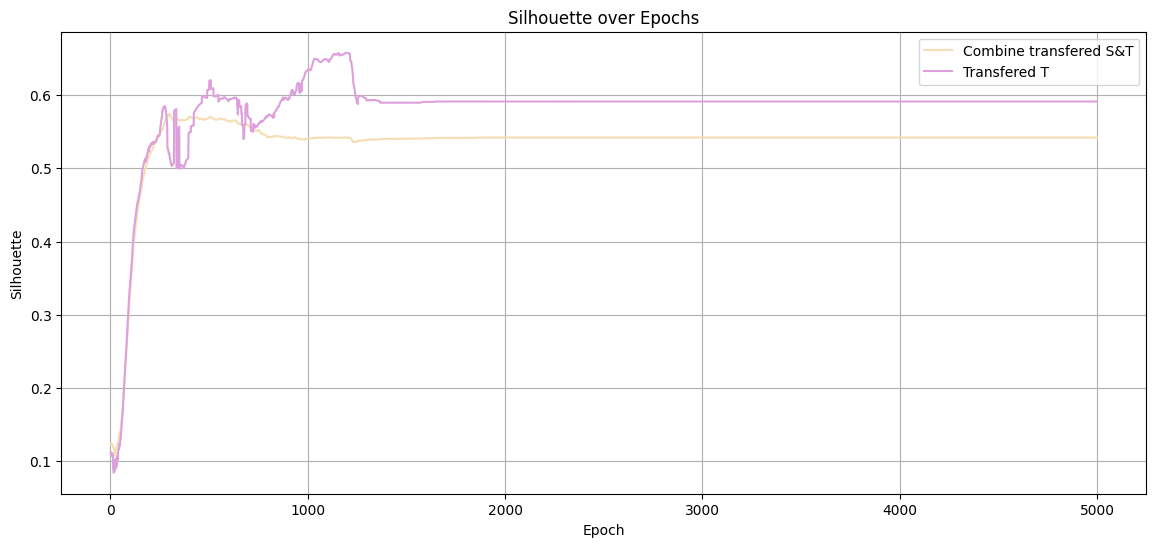

In [25]:
plt.figure(figsize=(14, 6))
plt.plot(epochs, silhouette_comb, linestyle='-', color='wheat', label="Combine transfered S&T")
plt.plot(epochs, sil_Tonly, linestyle='-', color='plum', label="Transfered T")

plt.title('Silhouette over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Silhouette')
plt.grid(True)
plt.legend()
plt.show()

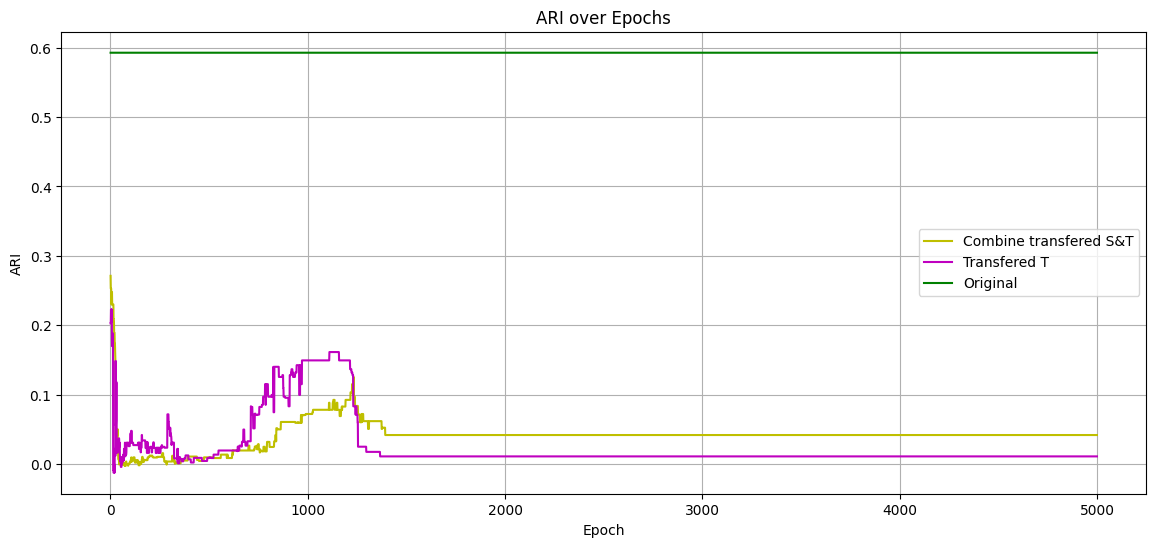

In [26]:


plt.figure(figsize=(14, 6))

plt.plot(epochs, ari_comb, linestyle='-', color='y', label="Combine transfered S&T")
plt.plot(epochs, ari_Tonly, linestyle='-', color='m', label="Transfered T")
plt.plot(epochs, [original_ari]*len(epochs), linestyle='-', color='green', label='Original')

plt.title('ARI over Epochs')
plt.xlabel('Epoch')
plt.ylabel('ARI')
plt.grid(True)
plt.legend()
plt.show()

In [27]:
xs_hat = final_model.extract_feature(xs.cuda())
xt_hat = final_model.extract_feature(xt.cuda())
xs_hat = xs_hat.cpu().numpy()
xt_hat = xt_hat.cpu().numpy()

x_comb = np.vstack((xs_hat, xt_hat))
comb_cluster_labels, model2 = clustering(x_comb,2)
ari = adjusted_rand_score(Yt, comb_cluster_labels[ns:])
print(f'Adjusted Rand Index (ARI) of target on transported domain: {ari:.4f}')

Adjusted Rand Index (ARI) of target on transported domain: 0.0792


Running t-SNE dimensionality reduction...


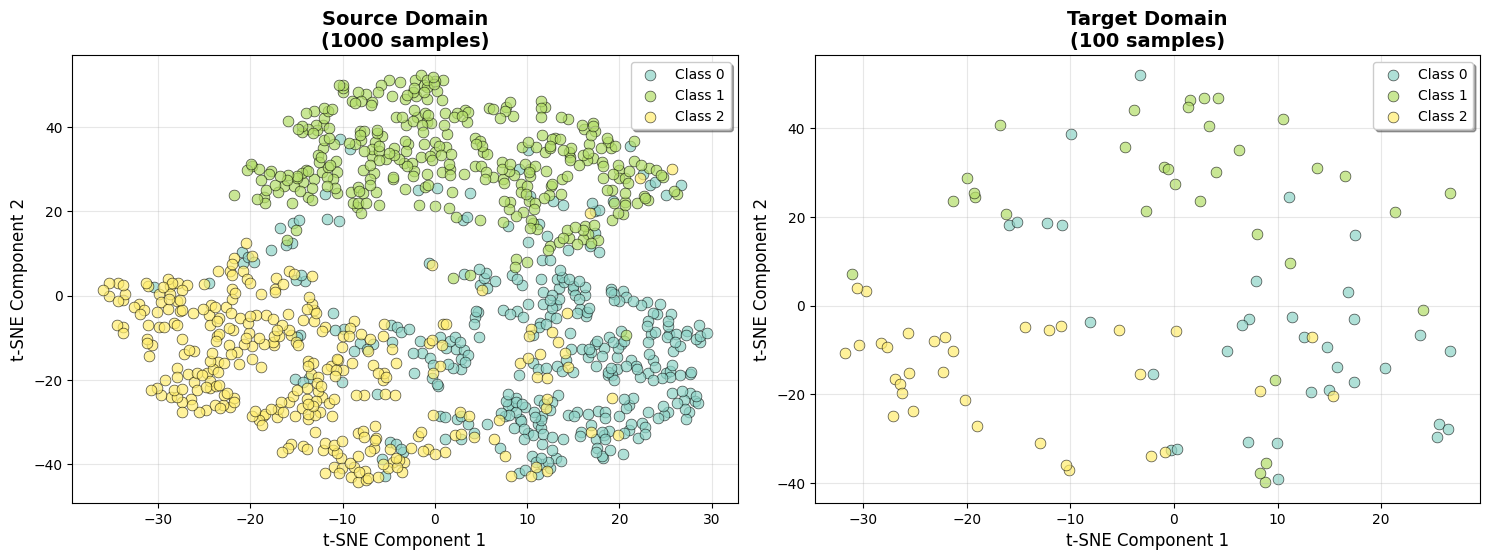

In [28]:
gendata.visualby_tsne(xs_hat, xt_hat, Ys, Yt)


## Fine-tune hyperparams

In [97]:
n_source_small = 1500
n_target_small = 150

# Randomly pick indices without replacement
src_indices = torch.randperm(len(xs))[:n_source_small]
tgt_indices = torch.randperm(len(xt))[:n_target_small]

# Create smaller tensors
xs_small = xs[src_indices]
xt_small = xt[tgt_indices]

# Subset labels (Ys, Yt are numpy arrays)
Ys_small = Ys[src_indices.cpu().numpy()]
Yt_small = Yt[tgt_indices.cpu().numpy()]

# Create smaller datasets
source_dataset_small = TensorDataset(xs_small)
target_dataset_small = TensorDataset(xt_small)

In [98]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [101]:
import numpy as np
from sklearn.metrics import adjusted_rand_score,silhouette_score

def objective(trial):
    
    alpha2 = 0.0001#trial.suggest_float("alpha2", 1e-4, 1e-2, log=True)
    alpha1  = 0.001#trial.suggest_float("alpha1", 1e-4, 1e-2, log=True)
    gamma = trial.suggest_float("gamma", 0.1, 13.0)
    lambda_ = trial.suggest_float("lambda_", 0.1, 10.0)
    # dc_iter = trial.suggest_int("dc_iter", 5, 15)
    batch_size = 32 #trial.suggest_categorical("batch_size", [16, 32, 64])

    # Build WDGRL tune_model
    tune_model = WDGRL(
        input_dim=d,
        encoder_hidden_dims=encoder_hidden_dims,
        decoder_hidden_dims=decoder_hidden_dims,
        critic_hidden_dims=critic_hidden_dims,
        use_decoder=True,
        alpha2=alpha2,
        alpha1=alpha1,
        seed=42
    )

    # Train (shorter epochs for tuning)
    loss = tune_model.train(
        source_dataset_small, 
        target_dataset_small,
        num_epochs=700,
        with_decoder=True,
        gamma=gamma,
        lambda_= lambda_,
        dc_iter=3,
        batch_size=batch_size, early_stopping=False
    )

    xs_small_hat = tune_model.extract_feature(xs_small.cuda())
    xt_small_hat = tune_model.extract_feature(xt_small.cuda())
    xs_small_hat = xs_small_hat.cpu().numpy()
    xt_small_hat = xt_small_hat.cpu().numpy()
    
    # Combine and cluster
    x_small_comb = np.vstack((xs_small_hat, xt_small_hat))
    comb_sm_cluster_labels, _ = clustering(x_small_comb,2)
    print("Loss: ",loss["loss"][-1])
    # Compute ARI on transported target domain
    ari = adjusted_rand_score(Yt_small, comb_sm_cluster_labels[len(xs_small_hat):])
    return ari  # Optuna will maximize this

    # # Combine and cluster
    # x_small_comb = np.vstack((xs_small_hat, xt_small_hat))
    # comb_sm_cluster_labels, _ = clustering(x_small_comb, 2)
    # print("Loss: ",loss["loss"][-1])
    # # Compute silhouette_score on transported target domain
    # scr = silhouette_score(x_small_comb, comb_sm_cluster_labels)
    # return scr  # Optuna will maximize this


In [102]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=80)

print("Best params:", study.best_params)
print("Best silhouette_score:", study.best_value)

[I 2025-08-17 00:20:17,866] A new study created in memory with name: no-name-88e664ab-fca0-4039-bb44-c10a9262e36a
Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.58it/s]
[I 2025-08-17 00:20:29,632] Trial 0 finished with value: 0.007207930635617119 and parameters: {'gamma': 8.009956888241076, 'lambda_': 7.653077545649711}. Best is trial 0 with value: 0.007207930635617119.


Loss:  5.9883036613464355


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.24it/s]
[I 2025-08-17 00:20:41,269] Trial 1 finished with value: 0.019141251046525535 and parameters: {'gamma': 6.4393075577387915, 'lambda_': 9.508186969230055}. Best is trial 1 with value: 0.019141251046525535.


Loss:  5.6614155769348145


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.01it/s]
[I 2025-08-17 00:20:52,956] Trial 2 finished with value: 0.0 and parameters: {'gamma': 0.9514186326055729, 'lambda_': 9.395326494818073}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.3180121183395386


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.49it/s]
[I 2025-08-17 00:21:04,547] Trial 3 finished with value: 0.0029347940386398614 and parameters: {'gamma': 3.8145059246146227, 'lambda_': 0.7917016963471872}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2744640111923218


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.50it/s]
[I 2025-08-17 00:21:16,326] Trial 4 finished with value: 0.0003580682931719957 and parameters: {'gamma': 6.897085311884918, 'lambda_': 2.50095849757522}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.19809889793396


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.71it/s]
[I 2025-08-17 00:21:28,069] Trial 5 finished with value: -0.0003532940492630358 and parameters: {'gamma': 3.3463238014453314, 'lambda_': 5.156902232147772}. Best is trial 1 with value: 0.019141251046525535.


Loss:  2.333789825439453


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.67it/s]
[I 2025-08-17 00:21:39,822] Trial 6 finished with value: 0.0003580682931719957 and parameters: {'gamma': 9.545619726681457, 'lambda_': 6.111161067159789}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2331573963165283


Epoch: 100%|██████████| 700/700 [00:12<00:00, 57.06it/s]
[I 2025-08-17 00:21:52,106] Trial 7 finished with value: 0.0 and parameters: {'gamma': 9.489488373217334, 'lambda_': 1.6000727520924185}. Best is trial 1 with value: 0.019141251046525535.


Loss:  4.035076141357422


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.48it/s]
[I 2025-08-17 00:22:03,888] Trial 8 finished with value: -0.003255588941081283 and parameters: {'gamma': 0.868701935770298, 'lambda_': 7.266210516506458}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.5925997495651245


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.55it/s]
[I 2025-08-17 00:22:15,664] Trial 9 finished with value: 0.0 and parameters: {'gamma': 7.85798909115142, 'lambda_': 0.8584246586104699}. Best is trial 1 with value: 0.019141251046525535.


Loss:  4.263916015625


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.33it/s]
[I 2025-08-17 00:22:27,486] Trial 10 finished with value: 0.0003580682931719957 and parameters: {'gamma': 12.975512828217216, 'lambda_': 9.784886833243055}. Best is trial 1 with value: 0.019141251046525535.


Loss:  12.682031631469727


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.99it/s]
[I 2025-08-17 00:22:39,181] Trial 11 finished with value: 0.0 and parameters: {'gamma': 5.236952593064822, 'lambda_': 7.877894474280923}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2421414852142334


Epoch: 100%|██████████| 700/700 [00:11<00:00, 58.77it/s]
[I 2025-08-17 00:22:51,115] Trial 12 finished with value: 0.0003580682931719957 and parameters: {'gamma': 9.146852454243403, 'lambda_': 7.871368226496096}. Best is trial 1 with value: 0.019141251046525535.


Loss:  44.93793487548828


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.44it/s]
[I 2025-08-17 00:23:02,718] Trial 13 finished with value: -0.0003485801328424561 and parameters: {'gamma': 11.738369993602383, 'lambda_': 8.796191556710113}. Best is trial 1 with value: 0.019141251046525535.


Loss:  10.593338012695312


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.42it/s]
[I 2025-08-17 00:23:14,328] Trial 14 finished with value: 0.0 and parameters: {'gamma': 5.281990301958498, 'lambda_': 6.454715468541115}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2417773008346558


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.57it/s]
[I 2025-08-17 00:23:25,905] Trial 15 finished with value: 0.0032539982129290283 and parameters: {'gamma': 8.174657579901615, 'lambda_': 3.8442325504495605}. Best is trial 1 with value: 0.019141251046525535.


Loss:  3.8873543739318848


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.59it/s]
[I 2025-08-17 00:23:37,679] Trial 16 finished with value: 0.0 and parameters: {'gamma': 5.69362560785069, 'lambda_': 8.380411875202798}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2403823137283325


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.20it/s]
[I 2025-08-17 00:23:49,525] Trial 17 finished with value: 0.0 and parameters: {'gamma': 11.02356373913552, 'lambda_': 6.744780712177301}. Best is trial 1 with value: 0.019141251046525535.


Loss:  5.519061088562012


Epoch: 100%|██████████| 700/700 [00:12<00:00, 57.25it/s]
[I 2025-08-17 00:24:01,780] Trial 18 finished with value: 0.0 and parameters: {'gamma': 3.728609123483186, 'lambda_': 9.99497937155286}. Best is trial 1 with value: 0.019141251046525535.


Loss:  6.403459548950195


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.50it/s]
[I 2025-08-17 00:24:13,371] Trial 19 finished with value: 0.0003580682931719957 and parameters: {'gamma': 7.0358875707304005, 'lambda_': 4.931538845299926}. Best is trial 1 with value: 0.019141251046525535.


Loss:  2.111057758331299


Epoch: 100%|██████████| 700/700 [00:12<00:00, 57.95it/s]
[I 2025-08-17 00:24:25,474] Trial 20 finished with value: -0.0033784228994775426 and parameters: {'gamma': 1.9824383929227203, 'lambda_': 8.878339969436714}. Best is trial 1 with value: 0.019141251046525535.


Loss:  2.3811278343200684


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.45it/s]
[I 2025-08-17 00:24:37,079] Trial 21 finished with value: 0.005051440341509865 and parameters: {'gamma': 8.307699613196633, 'lambda_': 3.5676751722667044}. Best is trial 1 with value: 0.019141251046525535.


Loss:  2.520122766494751


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.24it/s]
[I 2025-08-17 00:24:48,725] Trial 22 finished with value: 0.0007356102221160735 and parameters: {'gamma': 8.364577409398034, 'lambda_': 3.66183344582835}. Best is trial 1 with value: 0.019141251046525535.


Loss:  2.586841583251953


Epoch: 100%|██████████| 700/700 [00:12<00:00, 57.63it/s]
[I 2025-08-17 00:25:00,894] Trial 23 finished with value: 0.0 and parameters: {'gamma': 10.400784930436888, 'lambda_': 3.3723534395056167}. Best is trial 1 with value: 0.019141251046525535.


Loss:  3.478801727294922


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.74it/s]
[I 2025-08-17 00:25:12,631] Trial 24 finished with value: 0.0003580682931719957 and parameters: {'gamma': 6.092954943161451, 'lambda_': 5.214819740490227}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2559860944747925


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.44it/s]
[I 2025-08-17 00:25:24,241] Trial 25 finished with value: 0.0003580682931719957 and parameters: {'gamma': 7.374596147035985, 'lambda_': 2.6979982831671814}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2042052745819092


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.20it/s]
[I 2025-08-17 00:25:35,891] Trial 26 finished with value: -0.0021365269461077843 and parameters: {'gamma': 4.553569922137994, 'lambda_': 4.55875113884743}. Best is trial 1 with value: 0.019141251046525535.


Loss:  2.0036818981170654


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.45it/s]
[I 2025-08-17 00:25:47,686] Trial 27 finished with value: 0.0 and parameters: {'gamma': 8.876780880306194, 'lambda_': 5.623591895275565}. Best is trial 1 with value: 0.019141251046525535.


Loss:  18.190420150756836


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.85it/s]
[I 2025-08-17 00:25:59,407] Trial 28 finished with value: 0.018864312854722776 and parameters: {'gamma': 6.640228333279397, 'lambda_': 7.197709183350352}. Best is trial 1 with value: 0.019141251046525535.


Loss:  4.5207366943359375


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.08it/s]
[I 2025-08-17 00:26:11,278] Trial 29 finished with value: 0.010479106472896632 and parameters: {'gamma': 6.4514607133679895, 'lambda_': 7.241778232185527}. Best is trial 1 with value: 0.019141251046525535.


Loss:  4.244104385375977


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.17it/s]
[I 2025-08-17 00:26:22,932] Trial 30 finished with value: 0.0003580682931719957 and parameters: {'gamma': 6.37451261505673, 'lambda_': 7.0081406624040214}. Best is trial 1 with value: 0.019141251046525535.


Loss:  0.4900065064430237


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.09it/s]
[I 2025-08-17 00:26:34,607] Trial 31 finished with value: 0.015541346127399335 and parameters: {'gamma': 6.6820976714677105, 'lambda_': 7.710464573456562}. Best is trial 1 with value: 0.019141251046525535.


Loss:  5.028418064117432


Epoch: 100%|██████████| 700/700 [00:12<00:00, 55.73it/s]
[I 2025-08-17 00:26:47,189] Trial 32 finished with value: 0.0 and parameters: {'gamma': 4.961176707269194, 'lambda_': 9.136307101489871}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.239039659500122


Epoch: 100%|██████████| 700/700 [00:11<00:00, 58.46it/s]
[I 2025-08-17 00:26:59,188] Trial 33 finished with value: 0.015541346127399335 and parameters: {'gamma': 6.407408461812417, 'lambda_': 8.10655462334975}. Best is trial 1 with value: 0.019141251046525535.


Loss:  5.0051140785217285


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.14it/s]
[I 2025-08-17 00:27:11,048] Trial 34 finished with value: -0.002276910051290269 and parameters: {'gamma': 2.5125253041604356, 'lambda_': 8.191839831057354}. Best is trial 1 with value: 0.019141251046525535.


Loss:  2.3747262954711914


Epoch: 100%|██████████| 700/700 [00:12<00:00, 57.33it/s]
[I 2025-08-17 00:27:23,280] Trial 35 finished with value: 0.0 and parameters: {'gamma': 4.437544082531172, 'lambda_': 9.36269499579907}. Best is trial 1 with value: 0.019141251046525535.


Loss:  17.88410758972168


Epoch: 100%|██████████| 700/700 [00:11<00:00, 58.56it/s]
[I 2025-08-17 00:27:35,256] Trial 36 finished with value: 0.0003580682931719957 and parameters: {'gamma': 7.086005435328415, 'lambda_': 8.27691884212015}. Best is trial 1 with value: 0.019141251046525535.


Loss:  0.24554729461669922


Epoch: 100%|██████████| 700/700 [00:12<00:00, 57.11it/s]
[I 2025-08-17 00:27:47,536] Trial 37 finished with value: 0.0 and parameters: {'gamma': 5.897457725944165, 'lambda_': 6.067827110724245}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2435081005096436


Epoch: 100%|██████████| 700/700 [00:11<00:00, 58.78it/s]
[I 2025-08-17 00:27:59,466] Trial 38 finished with value: 0.002149148519296369 and parameters: {'gamma': 2.9499325025238554, 'lambda_': 7.564621345858795}. Best is trial 1 with value: 0.019141251046525535.


Loss:  8.312368392944336


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.92it/s]
[I 2025-08-17 00:28:11,168] Trial 39 finished with value: 0.009723624846873226 and parameters: {'gamma': 7.409705546484059, 'lambda_': 8.702940691006829}. Best is trial 1 with value: 0.019141251046525535.


Loss:  6.9159135818481445


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.92it/s]
[I 2025-08-17 00:28:22,875] Trial 40 finished with value: 0.0 and parameters: {'gamma': 4.530293395741248, 'lambda_': 9.47390455260491}. Best is trial 1 with value: 0.019141251046525535.


Loss:  3.330918788909912


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.63it/s]
[I 2025-08-17 00:28:34,448] Trial 41 finished with value: 0.0075601777935348025 and parameters: {'gamma': 6.517799487931111, 'lambda_': 7.354134161157457}. Best is trial 1 with value: 0.019141251046525535.


Loss:  4.3050079345703125


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.14it/s]
[I 2025-08-17 00:28:46,110] Trial 42 finished with value: 0.0 and parameters: {'gamma': 6.754343844475684, 'lambda_': 6.617936774154902}. Best is trial 1 with value: 0.019141251046525535.


Loss:  4.31904411315918


Epoch: 100%|██████████| 700/700 [00:12<00:00, 55.36it/s]
[I 2025-08-17 00:28:58,777] Trial 43 finished with value: 0.0003580682931719957 and parameters: {'gamma': 5.732496339476248, 'lambda_': 7.802225814821657}. Best is trial 1 with value: 0.019141251046525535.


Loss:  22.72926139831543


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.06it/s]
[I 2025-08-17 00:29:10,650] Trial 44 finished with value: 0.0003580682931719957 and parameters: {'gamma': 7.74468477941111, 'lambda_': 7.138420514752445}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2456631660461426


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.52it/s]
[I 2025-08-17 00:29:22,433] Trial 45 finished with value: -0.0021365269461077843 and parameters: {'gamma': 0.2003794341509213, 'lambda_': 6.04813074166062}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.0142290592193604


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.12it/s]
[I 2025-08-17 00:29:34,107] Trial 46 finished with value: 0.012598673672836113 and parameters: {'gamma': 6.6102085917381395, 'lambda_': 8.557706912676059}. Best is trial 1 with value: 0.019141251046525535.


Loss:  6.272906303405762


Epoch: 100%|██████████| 700/700 [00:12<00:00, 57.94it/s]
[I 2025-08-17 00:29:46,211] Trial 47 finished with value: 0.0 and parameters: {'gamma': 5.420552621873475, 'lambda_': 8.556529416781272}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2429718971252441


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.32it/s]
[I 2025-08-17 00:29:58,039] Trial 48 finished with value: 0.0003580682931719957 and parameters: {'gamma': 8.767209706154457, 'lambda_': 9.140151235513839}. Best is trial 1 with value: 0.019141251046525535.


Loss:  13.762301445007324


Epoch: 100%|██████████| 700/700 [00:12<00:00, 57.12it/s]
[I 2025-08-17 00:30:10,317] Trial 49 finished with value: 0.0003580682931719957 and parameters: {'gamma': 10.09824078257919, 'lambda_': 9.518749038599118}. Best is trial 1 with value: 0.019141251046525535.


Loss:  14.456622123718262


Epoch: 100%|██████████| 700/700 [00:12<00:00, 57.33it/s]
[I 2025-08-17 00:30:22,552] Trial 50 finished with value: 0.0010743908204048304 and parameters: {'gamma': 7.671240360824356, 'lambda_': 7.9525263833192685}. Best is trial 1 with value: 0.019141251046525535.


Loss:  8.417525291442871


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.36it/s]
[I 2025-08-17 00:30:34,173] Trial 51 finished with value: 0.0 and parameters: {'gamma': 6.3936192845756254, 'lambda_': 7.513749829017735}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2347328662872314


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.59it/s]
[I 2025-08-17 00:30:45,557] Trial 52 finished with value: 0.0003580682931719957 and parameters: {'gamma': 6.966932999552653, 'lambda_': 8.166714983063248}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2425159215927124


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.09it/s]
[I 2025-08-17 00:30:57,228] Trial 53 finished with value: 0.0 and parameters: {'gamma': 4.988181607861766, 'lambda_': 8.935960960865788}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.243105411529541


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.03it/s]
[I 2025-08-17 00:31:08,721] Trial 54 finished with value: 0.0003580682931719957 and parameters: {'gamma': 6.129788630462857, 'lambda_': 6.94088562410506}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2280365228652954


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.78it/s]
[I 2025-08-17 00:31:20,261] Trial 55 finished with value: 0.0 and parameters: {'gamma': 6.80345538287317, 'lambda_': 7.704934234761117}. Best is trial 1 with value: 0.019141251046525535.


Loss:  11.626189231872559


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.64it/s]
[I 2025-08-17 00:31:31,640] Trial 56 finished with value: 0.0 and parameters: {'gamma': 4.092674398512527, 'lambda_': 9.71774260921934}. Best is trial 1 with value: 0.019141251046525535.


Loss:  25.220600128173828


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.44it/s]
[I 2025-08-17 00:31:43,053] Trial 57 finished with value: 0.0 and parameters: {'gamma': 5.503342191297796, 'lambda_': 8.255160212419996}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2159037590026855


Epoch: 100%|██████████| 700/700 [00:12<00:00, 57.52it/s]
[I 2025-08-17 00:31:55,242] Trial 58 finished with value: 0.007207930635617119 and parameters: {'gamma': 8.162874431155393, 'lambda_': 6.448664831667298}. Best is trial 1 with value: 0.019141251046525535.


Loss:  5.240139484405518


Epoch: 100%|██████████| 700/700 [00:11<00:00, 62.32it/s]
[I 2025-08-17 00:32:06,497] Trial 59 finished with value: 0.0003580682931719957 and parameters: {'gamma': 7.482315654086063, 'lambda_': 9.98692055459003}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2518972158432007


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.94it/s]
[I 2025-08-17 00:32:17,818] Trial 60 finished with value: 0.0 and parameters: {'gamma': 5.868993371253053, 'lambda_': 8.56872324124937}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2049014568328857


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.78it/s]
[I 2025-08-17 00:32:29,169] Trial 61 finished with value: 0.007207930635617119 and parameters: {'gamma': 7.398561180787235, 'lambda_': 8.781982983537265}. Best is trial 1 with value: 0.019141251046525535.


Loss:  7.045513153076172


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.72it/s]
[I 2025-08-17 00:32:40,529] Trial 62 finished with value: 0.0 and parameters: {'gamma': 6.467160441861031, 'lambda_': 0.32500560948600654}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.7586283683776855


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.91it/s]
[I 2025-08-17 00:32:52,235] Trial 63 finished with value: 0.0003580682931719957 and parameters: {'gamma': 7.097685686694982, 'lambda_': 9.158097168971619}. Best is trial 1 with value: 0.019141251046525535.


Loss:  0.21293413639068604


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.12it/s]
[I 2025-08-17 00:33:03,708] Trial 64 finished with value: 0.0010743908204048304 and parameters: {'gamma': 7.848234300123218, 'lambda_': 8.705870942104777}. Best is trial 1 with value: 0.019141251046525535.


Loss:  9.329621315002441


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.04it/s]
[I 2025-08-17 00:33:15,199] Trial 65 finished with value: 0.0003580682931719957 and parameters: {'gamma': 8.59269199834586, 'lambda_': 7.980456007122876}. Best is trial 1 with value: 0.019141251046525535.


Loss:  31.53243064880371


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.46it/s]
[I 2025-08-17 00:33:26,613] Trial 66 finished with value: 0.0003580682931719957 and parameters: {'gamma': 9.455631847954923, 'lambda_': 7.4102311683219995}. Best is trial 1 with value: 0.019141251046525535.


Loss:  43.78408432006836


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.61it/s]
[I 2025-08-17 00:33:37,997] Trial 67 finished with value: 0.0003580682931719957 and parameters: {'gamma': 4.9156509756436435, 'lambda_': 8.433402401944184}. Best is trial 1 with value: 0.019141251046525535.


Loss:  37.204444885253906


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.47it/s]
[I 2025-08-17 00:33:49,790] Trial 68 finished with value: 0.0003580682931719957 and parameters: {'gamma': 6.216339372893267, 'lambda_': 6.362762316000297}. Best is trial 1 with value: 0.019141251046525535.


Loss:  0.8985347747802734


Epoch: 100%|██████████| 700/700 [00:12<00:00, 57.50it/s]
[I 2025-08-17 00:34:01,984] Trial 69 finished with value: 0.0003580682931719957 and parameters: {'gamma': 7.159814998477124, 'lambda_': 6.8346758632921745}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2415962219238281


Epoch: 100%|██████████| 700/700 [00:11<00:00, 60.57it/s]
[I 2025-08-17 00:34:13,565] Trial 70 finished with value: 0.007207930635617119 and parameters: {'gamma': 8.08882254181159, 'lambda_': 8.999130952213468}. Best is trial 1 with value: 0.019141251046525535.


Loss:  7.038159370422363


Epoch: 100%|██████████| 700/700 [00:11<00:00, 58.38it/s]
[I 2025-08-17 00:34:25,578] Trial 71 finished with value: 0.018864312854722776 and parameters: {'gamma': 6.641748939397019, 'lambda_': 7.265108828269401}. Best is trial 1 with value: 0.019141251046525535.


Loss:  4.543869972229004


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.07it/s]
[I 2025-08-17 00:34:37,061] Trial 72 finished with value: 0.0 and parameters: {'gamma': 6.745075864801125, 'lambda_': 7.277268485333117}. Best is trial 1 with value: 0.019141251046525535.


Loss:  -1.31112802028656


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.24it/s]
[I 2025-08-17 00:34:48,897] Trial 73 finished with value: 0.0003580682931719957 and parameters: {'gamma': 6.097738224166211, 'lambda_': 8.081446221497284}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2499914169311523


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.42it/s]
[I 2025-08-17 00:35:00,317] Trial 74 finished with value: 0.0 and parameters: {'gamma': 5.322902340857466, 'lambda_': 5.746246233098749}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2374036312103271


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.25it/s]
[I 2025-08-17 00:35:11,775] Trial 75 finished with value: 0.005051440341509865 and parameters: {'gamma': 7.357882382847214, 'lambda_': 7.681305236207469}. Best is trial 1 with value: 0.019141251046525535.


Loss:  6.1598896980285645


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.37it/s]
[I 2025-08-17 00:35:23,205] Trial 76 finished with value: 0.014985360437164747 and parameters: {'gamma': 6.650187908943946, 'lambda_': 7.135778409825059}. Best is trial 1 with value: 0.019141251046525535.


Loss:  4.442400932312012


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.39it/s]
[I 2025-08-17 00:35:34,629] Trial 77 finished with value: 0.0003580682931719957 and parameters: {'gamma': 5.725339446086307, 'lambda_': 7.097924227736683}. Best is trial 1 with value: 0.019141251046525535.


Loss:  12.236852645874023


Epoch: 100%|██████████| 700/700 [00:11<00:00, 59.75it/s]
[I 2025-08-17 00:35:46,366] Trial 78 finished with value: 0.0003580682931719957 and parameters: {'gamma': 6.857906366040125, 'lambda_': 6.620179868249241}. Best is trial 1 with value: 0.019141251046525535.


Loss:  1.2622950077056885


Epoch: 100%|██████████| 700/700 [00:11<00:00, 61.42it/s]
[I 2025-08-17 00:35:57,783] Trial 79 finished with value: 0.014985360437164747 and parameters: {'gamma': 6.604372914347948, 'lambda_': 6.238554524198862}. Best is trial 1 with value: 0.019141251046525535.


Loss:  4.031076431274414
Best params: {'gamma': 6.4393075577387915, 'lambda_': 9.508186969230055}
Best silhouette_score: 0.019141251046525535


In [103]:
# Assuming 'study' is your Optuna study object after optimization
best_trial = study.best_trial

print("Best Trial:")
print(f"  Value: {best_trial.value}")

print("\n  Directly Suggested Parameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

print("\n  Dynamically Generated Architecture (User Attributes):")
for key, value in best_trial.user_attrs.items():
    print(f"    {key}: {value}")

Best Trial:
  Value: 0.019141251046525535

  Directly Suggested Parameters:
    gamma: 6.4393075577387915
    lambda_: 9.508186969230055

  Dynamically Generated Architecture (User Attributes):


In [104]:
# best_trial.user_attrs["critic_hidden_dims"]

In [112]:
best_params = study.best_params

final_model = WDGRL(
    input_dim=d,
    encoder_hidden_dims=encoder_hidden_dims,
    decoder_hidden_dims=decoder_hidden_dims,
    critic_hidden_dims=critic_hidden_dims,
    alpha2=0.0001,#best_params["alpha2"],
    alpha1=0.001,#best_params["alpha1"],
    use_decoder=True,
    seed=42
)   

# Train longer for final fit
log_loss = final_model.train(
    source_dataset,
    target_dataset,
    num_epochs=1000,  # more epochs for final training
    gamma=best_params["gamma"],
    with_decoder=True,
    lambda_= best_params["lambda_"],
    dc_iter=dc_iter,
    batch_size=batch_size,
    verbose = False,
    early_stopping=False,
)

Epoch: 100%|██████████| 1000/1000 [00:16<00:00, 60.56it/s]


In [113]:
xs_hat = final_model.extract_feature(xs.cuda())
xt_hat = final_model.extract_feature(xt.cuda())
xs_hat = xs_hat.cpu().numpy()
xt_hat = xt_hat.cpu().numpy()

x_comb = np.vstack((xs_hat, xt_hat))
comb_cluster_labels, model2 = clustering(x_comb,2)
ari = adjusted_rand_score(Yt, comb_cluster_labels[ns:])
print(f'Adjusted Rand Index (ARI) of target on transported domain: {ari:.4f}')

Adjusted Rand Index (ARI) of target on transported domain: 0.0006


In [114]:
# gendata.visualby_tsne(xs_hat, xt_hat, Ys, Yt)

In [115]:
total_loss = log_loss["loss"]
reconstructionloss = log_loss["decoder_loss"]

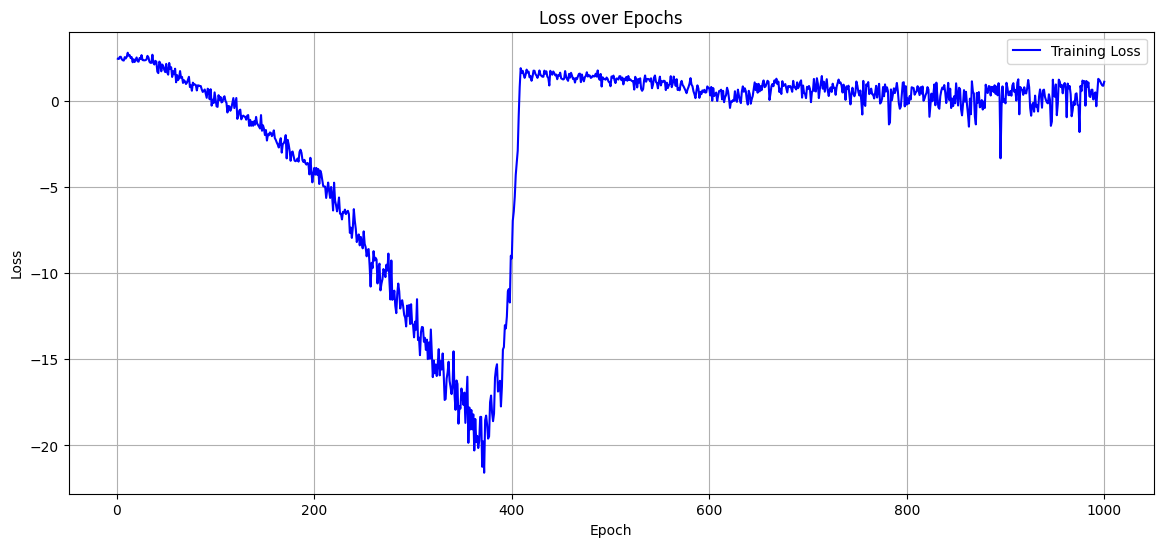

In [116]:
epochs = range(1, len(total_loss) + 1)

plt.figure(figsize=(14, 6))
plt.plot(epochs, total_loss, linestyle='-', color='blue', label='Training Loss')

plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

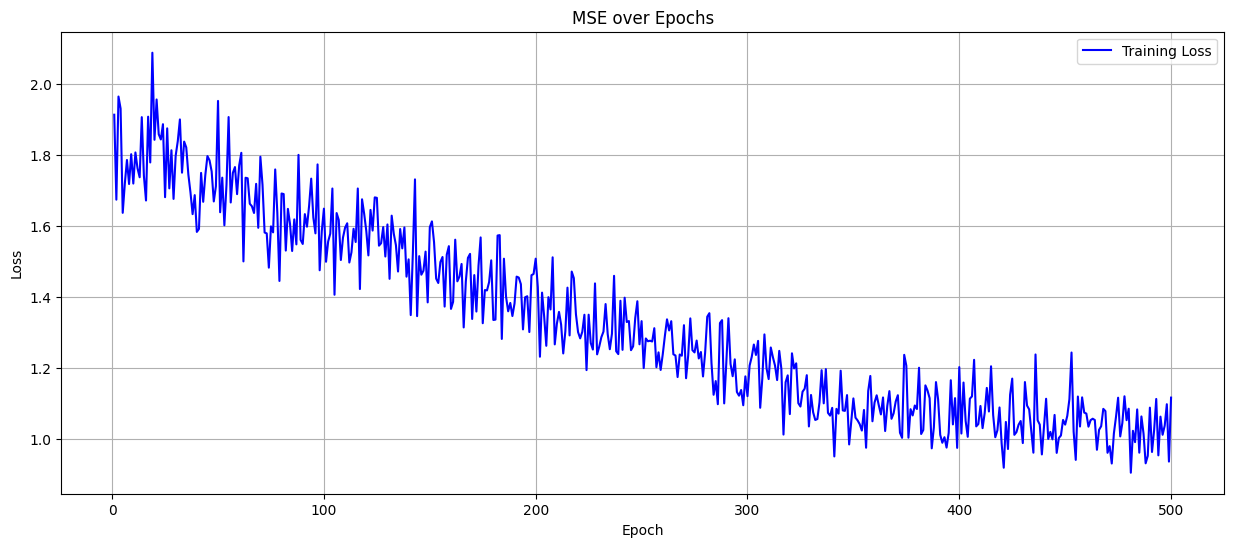

In [ ]:
epochs_ = range(1, len(reconstructionloss) + 1)

plt.figure(figsize=(15, 6))
plt.plot(epochs, reconstructionloss, color='blue', label='Training Loss')

plt.title('MSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()